In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
import re
import random

In [2]:
def create_sequences_and_targets(encoded_sentences_ids, max_sequence_length=30):
    X_samples = []
    y_samples = []

    for sentence_ids in encoded_sentences_ids:
        if len(sentence_ids) < max_sequence_length + 1:
            continue
        # Sliding window within each sentence
        for i in range(len(sentence_ids) - max_sequence_length):
            input_seq = sentence_ids[i:i+max_sequence_length]
            target_seq = sentence_ids[i+1:i+max_sequence_length+1]

            X_samples.append(input_seq)
            y_samples.append(target_seq)

    X = torch.tensor(X_samples, dtype=torch.long)
    y = torch.tensor(y_samples, dtype=torch.long)

    return X, y

class NextWordPredictor(nn.Module):
    """
    Neural network for next word prediction with the following architecture:
    Embedding layer -> LSTM layer -> Attention layer -> Fully connected layer
    """
    def __init__(self, vocab_size, embeddings_matrix, hidden_dim, num_layers, pad_token_id):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embeddings_matrix.shape[1]
        self.embeddings_matrix = torch.from_numpy(embeddings_matrix).float()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.pad_token_id = pad_token_id

        self.embedding = nn.Embedding.from_pretrained(self.embeddings_matrix, freeze=False, padding_idx=self.pad_token_id)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.attention = nn.Linear(self.hidden_dim, 1)
        self.fc = nn.Linear(self.hidden_dim * 2, self.vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, hidden=None):
        batch_size, seq_len = input_ids.size()

        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)

        lstm_out, hidden = self.lstm(embedded, hidden)  # (batch_size, seq_len, hidden_dim)

        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attended_output = torch.bmm(attention_weights.transpose(1, 2), lstm_out)
        combined = torch.cat([lstm_out, attended_output.expand_as(lstm_out)], dim=-1)

        output = self.fc(combined) # (batch_size, hidden_dim*2, vocab_size)
        output = self.dropout(output)
        return output, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)

            hidden = model.init_hidden(batch_size, device)
            output_logits, hidden = model(inputs, hidden)

            predictions = torch.argmax(output_logits, dim=-1)  # (batch_size, seq_len)

            correct_predictions += (predictions == targets).sum().item()
            total_predictions += targets.numel()

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

def calculate_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(ignore_index=model.pad_token_id, reduction='sum')

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)

            hidden = model.init_hidden(batch_size, device)
            output_logits, hidden = model(inputs, hidden)

            loss = criterion(output_logits.view(-1, model.vocab_size), targets.view(-1))

            total_loss += loss.item()
            total_tokens += targets.numel()

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(avg_loss)

    return perplexity

def train_model(model, train_dataloader, val_dataloader, num_epochs, vocab_size, device="cpu", clip_grad_norm=1.0):
    model.train()
    print("Starting training...")
    metrics_history = []

    optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=num_epochs, pct_start=0.1)
    criterion = nn.CrossEntropyLoss(ignore_index=model.pad_token_id)

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size, device)
            optimizer.zero_grad()
            output_logits, hidden = model(inputs, hidden)

            hidden = (hidden[0].detach(), hidden[1].detach())
            loss = criterion(output_logits.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():

            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)

                batch_size = inputs.size(0)
                val_hidden = model.init_hidden(batch_size, device)
                output_logits, val_hidden = model(inputs, val_hidden)
                val_hidden = (val_hidden[0].detach(), val_hidden[1].detach())

                loss = criterion(output_logits.view(-1, vocab_size), targets.view(-1))
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
        scheduler.step()

        # Calculate accuracy and perplexity every 10 epochs
        if (epoch + 1) % 10 == 0:
            print("Calculating metrics...")
            train_accuracy = calculate_accuracy(model, train_dataloader, device)
            val_accuracy = calculate_accuracy(model, val_dataloader, device)

            train_perplexity = calculate_perplexity(model, train_dataloader, device)
            val_perplexity = calculate_perplexity(model, val_dataloader, device)

            print(f"Epoch [{epoch+1}/{num_epochs}]:")
            print(f"  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            print(f"  Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
            print(f"  Train Perplexity: {train_perplexity:.2f}, Val Perplexity: {val_perplexity:.2f}")
            print("-" * 60)
            metrics_history.append({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_perplexity": train_perplexity,
                "val_perplexity": val_perplexity
            })
        else:
            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        model.train()

    print("Training finished.")
    return metrics_history

def evaluate_model(model, test_dataloader, device):
    print("Evaluating model on test set...")

    test_accuracy = calculate_accuracy(model, test_dataloader, device)
    test_perplexity = calculate_perplexity(model, test_dataloader, device)

    print(f"Final Test Results:")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test Perplexity: {test_perplexity:.2f}")

    return test_accuracy, test_perplexity

def text_to_indices(text, word_to_idx, max_sequence_length=30):
    words = re.findall(r'\w+|[^\w\s]|\s+', text.lower())
    indices = []

    for word in words:
        if word in word_to_idx:
            indices.append(word_to_idx[word])
        else:
            indices.append(word_to_idx['<UNK>'])

    if max_sequence_length and len(indices) > max_sequence_length:
        indices = indices[-max_sequence_length:]

    return indices

def indices_to_text(indices, idx_to_word):
    words = []
    special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']
    for idx in indices:
        if idx in idx_to_word:
            if idx_to_word[idx] in special_tokens:
                continue
            words.append(idx_to_word[idx])
    content = ''.join(words)
    content = re.sub(r'\s+', ' ', content).strip()
    return content

def generate_text(model, word_to_idx, idx_to_word, start_text, num_words_to_generate, top5= False, max_sequence_length=30, device="cpu", temperature=1.0):

    model.eval()
    generated_ids = []
    prediction_details = []

    # Encode the start text
    current_input_ids = text_to_indices(start_text, word_to_idx, max_sequence_length)
    generated_ids.extend(current_input_ids)

    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor([current_input_ids], dtype=torch.long).to(device)
    hidden = model.init_hidden(1, device)
    print(f"Generating from: '{start_text}'")

    for i in range(num_words_to_generate):
        with torch.no_grad():
            output_logits, hidden = model(input_tensor, hidden)
            last_word_logits = output_logits[0, -1, :]
            probabilities = torch.softmax(last_word_logits / temperature, dim=-1)

            top_5_probs, top_5_indices = torch.topk(probabilities, 5)
            top_5_words_and_probs = []
            for j in range(len(top_5_indices)):
                word = idx_to_word.get(top_5_indices[j].item(), '<UNK>')
                prob = top_5_probs[j].item()
                top_5_words_and_probs.append(f"{word} ({prob:.4f})")

            top_k = 50
            top_k_probs, top_k_indices = torch.topk(probabilities, top_k)
            top_k_probs = top_k_probs / top_k_probs.sum()  # re-normalize

            predicted_id = torch.multinomial(top_k_probs, 1).item()
            predicted_id = top_k_indices[predicted_id].item()

            prediction_details.append({
                "step": i + 1,
                "top_5_alternatives": top_5_words_and_probs
            })
            cnt = 0
            while cnt<3:
                if predicted_id == word_to_idx[' ']:
                    break
                if predicted_id in generated_ids:
                    x = random.randint(0, 4)
                    predicted_id = top_5_indices[x].item()
                    cnt+=1
                else:
                    break

            generated_ids.append(predicted_id)

            current_input_ids.append(predicted_id)

            if len(current_input_ids) > max_sequence_length:
                current_input_ids = current_input_ids[1:]

            input_tensor = torch.tensor([current_input_ids], dtype=torch.long).to(device)

    generated_text = indices_to_text(generated_ids, idx_to_word)
    if top5 == True:
      print("\n--- Prediction Details ---")
      for detail in prediction_details:
          print(f"Step {detail['step']}:'")
          print(f"  Top 5 likely words: {', '.join(detail['top_5_alternatives'])}")
      print("--------------------------\n")

    return generated_text

In [5]:
# 1. Load data and embeddings from pickle file
with open("embeddings.pkl", 'rb') as f:
    embeddings = pickle.load(f)
with open("data.pkl", 'rb') as f:
    data = pickle.load(f)

train_sequences = data['train_sequences']
val_sequences = data['val_sequences']
test_sequences = data['test_sequences']

word_to_idx = embeddings['word_to_idx']
idx_to_word = embeddings['idx_to_word']
embeddings_matrix = embeddings['embeddings_matrix']

# 2. Initialize parameters
pad_token_id = word_to_idx["<PAD>"]
vocab_size = len(word_to_idx)
embedding_dim = embeddings_matrix.shape[1]
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Prepare train, val, test data loaders
X_train, y_train = create_sequences_and_targets(train_sequences)
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val, y_val = create_sequences_and_targets(val_sequences)
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_test, y_test = create_sequences_and_targets(test_sequences)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#4. Initialize, train and evaluate model
model = NextWordPredictor(vocab_size, embeddings_matrix, hidden_dim=256, num_layers=2, pad_token_id=pad_token_id)
model.to(device)

NextWordPredictor(
  (embedding): Embedding(4389, 384, padding_idx=0)
  (lstm): LSTM(384, 256, num_layers=2, batch_first=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (fc): Linear(in_features=512, out_features=4389, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [6]:
metrics = train_model(model, train_dataloader, val_dataloader, num_epochs=130, vocab_size=vocab_size, device=device)
evaluate_model(model, test_dataloader, device)

Starting training...
Epoch [1/130] Train Loss: 5.2261, Validation Loss: 3.6037
Epoch [2/130] Train Loss: 4.5629, Validation Loss: 3.2586
Epoch [3/130] Train Loss: 4.4309, Validation Loss: 3.0987
Epoch [4/130] Train Loss: 4.3345, Validation Loss: 2.9763
Epoch [5/130] Train Loss: 4.2611, Validation Loss: 2.8928
Epoch [6/130] Train Loss: 4.1999, Validation Loss: 2.8164
Epoch [7/130] Train Loss: 4.1390, Validation Loss: 2.7438
Epoch [8/130] Train Loss: 4.0800, Validation Loss: 2.6868
Epoch [9/130] Train Loss: 4.0303, Validation Loss: 2.6307
Calculating metrics...
Epoch [10/130]:
  Train Loss: 3.9813, Val Loss: 2.5846
  Train Accuracy: 0.5882, Val Accuracy: 0.5797
  Train Perplexity: 11.84, Val Perplexity: 13.25
------------------------------------------------------------
Epoch [11/130] Train Loss: 3.9383, Validation Loss: 2.5404
Epoch [12/130] Train Loss: 3.8954, Validation Loss: 2.4979
Epoch [13/130] Train Loss: 3.8562, Validation Loss: 2.4591
Epoch [14/130] Train Loss: 3.8181, Validation

(0.8133111584799294, 3.080114984556902)

In [7]:
start_seed_text = ["Boots which extended halfway", "I ordered him to pay", "I answered that it had", "remove crusted mud from it. Hence", "He never spoke of the"]
num_words = [50, 50, 50, 50, 10]
top_5 = [False, False, False, False, True]
for i in range(len(start_seed_text)):
    print(f"\n--- Generating text for seed: '{start_seed_text[i]}' ---")
    generated_output = generate_text(model, word_to_idx, idx_to_word, start_seed_text[i], num_words[i], top5=top_5[i], temperature= 0.5, max_sequence_length=30, device=device)
    print(f"Generated text: {generated_output}")
    print("----------------------")


--- Generating text for seed: 'Boots which extended halfway' ---
Generating from: 'Boots which extended halfway'
Generated text: boots which extended halfway up those side-sided brown, patentredshoes brick upon the right forefinger. indeed, we found us in lodgings to know ourselves again! right
----------------------

--- Generating text for seed: 'I ordered him to pay' ---
Generating from: 'I ordered him to pay'
Generated text: i ordered him to pay his brilliant advice and be found with whoever might think better than clearly that this floor, mr. holder! said holmes as to see
----------------------

--- Generating text for seed: 'I answered that it had' ---
Generating from: 'I answered that it had'
Generated text: i answered that it had it, since? because you come from home without self-respect in return of yours. by considering place lestrade took lestrade to post
----------------------

--- Generating text for seed: 'remove crusted mud from it. Hence' ---
Generating from: 'remove c

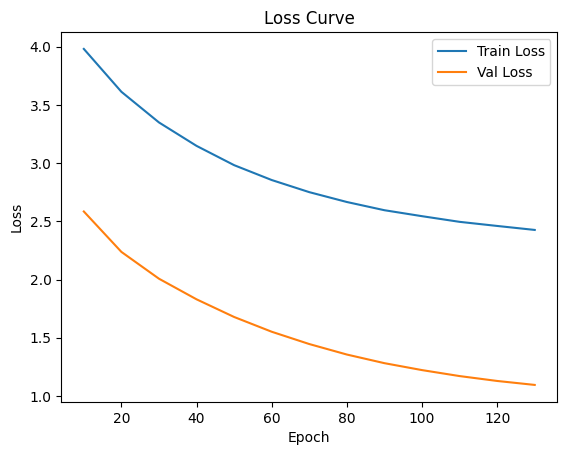

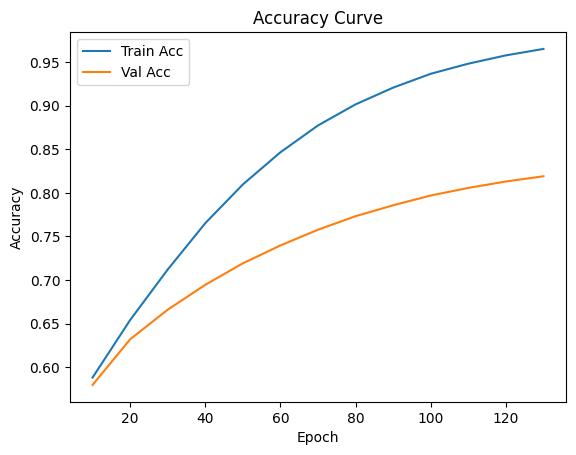

In [8]:
import matplotlib.pyplot as plt

epochs = [d['epoch'] for d in metrics]
train_losses = [d['train_loss'] for d in metrics]
val_losses = [d['val_loss'] for d in metrics]
train_acc = [d['train_accuracy'] for d in metrics]
val_acc = [d['val_accuracy'] for d in metrics]

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()